In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from mplsoccer import Pitch
from scipy.ndimage import gaussian_filter
from torch.utils.data import DataLoader

from datatools.preprocess import extract_match_id
from datatools.trace_snapshot import TraceSnapshot
from imputer.datasets import ImputerDataset
from imputer.components import press
import imputer.config as config

from datatools.utils import compute_camera_coverage, is_inside
# Define the path to the dataset
path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'DFL')
#path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'BEPRO', '2024')
path

'/root/geonhee/PlayerImputer/data/DFL'

In [2]:
# Define the path to the dataset
base_path = os.path.join(os.path.dirname(os.getcwd()))
base_path

'/root/geonhee/PlayerImputer'

In [3]:
match_ids = sorted([extract_match_id(filename) for filename in os.listdir(path)])
test_game_ids = ['DFL-MAT-J03YKM']#match_ids[11:12] #['DFL-MAT-J03YKM'] #match_ids[6:7]#[11:13]#['153381', '153385', '153387'] #match_ids[:40]   #match_ids[6:7]  
test_game_ids

['DFL-MAT-J03YKM']

In [4]:
#team_sheets = pd.read_csv(os.path.join(path, test_game_ids[2], 'teams.csv'))
team_sheets = pd.read_csv(os.path.join(path, test_game_ids[0], 'teams.csv'))

print(team_sheets["team_id"].unique())
team_sheets

['DFL-CLU-00000V' 'DFL-CLU-00000B']


,player,position,team,jID,player_id,team_id,xID
0,C. Trimmel,DRM,Home,28,DFL-OBJ-0002FX,DFL-CLU-00000V,0
1,K. Vogt,IVZ,Home,2,DFL-OBJ-000040,DFL-CLU-00000V,1
2,A. Schwolow,None,Home,37,DFL-OBJ-00001D,DFL-CLU-00000V,2
3,R. Knoche,None,Home,31,DFL-OBJ-0000UE,DFL-CLU-00000V,3
4,R. Khedira,DMZ,Home,8,DFL-OBJ-0001EA,DFL-CLU-00000V,4
5,Frederik Rønnow,TW,Home,1,DFL-OBJ-0028P2,DFL-CLU-00000V,5
6,Lucas Tousart,HR,Home,29,DFL-OBJ-002GDG,DFL-CLU-00000V,6
7,P. Jaeckel,None,Home,3,DFL-OBJ-002860,DFL-CLU-00000V,7
8,Robin Gosens,DLM,Home,6,DFL-OBJ-J019PZ,DFL-CLU-00000V,8
9,Diogo Leite,IVL,Home,4,DFL-OBJ-J019T5,DFL-CLU-00000V,9


In [5]:
#events = pd.read_csv(os.path.join(path, test_game_ids[2], 'events.csv'))
events = pd.read_csv(os.path.join(path, test_game_ids[0], 'events.csv'))
events["event_id"] = range(len(events))
events.head(2)

,type_name,time_seconds,team_id,player_id,outcome,timestamp,minute,second,qualifier,period_id,team,game_id,start_x,start_y,position,related_x,related_y,related_id,event_id
0,KickOff_Play_Pass,0.000,DFL-CLU-00000V,DFL-OBJ-J01GLO,NaN,2024-04-06 15:30:00.520000+02:00,0.0,0.0,"{'TeamLeft': 'DFL-CLU-00000B', 'GameSection': ...",1,Home,DFL-MAT-J03YKM,51.870000,34.51000,STR,52.670000,32.950000,DFL-OBJ-J01GUA,0
1,Play_Pass,0.739,DFL-CLU-00000V,DFL-OBJ-J01GUA,NaN,2024-04-06 15:30:01.259000+02:00,0.0,0.0,"{'PlayOrigin': 'ownHalf', 'FromOpenPlay': 'tru...",1,Home,DFL-MAT-J03YKM,52.919985,32.47997,HL,74.869962,38.440061,DFL-OBJ-J01GQO,1


In [26]:
events[events["time_seconds"] == 1487.411]#772.969]

,type_name,time_seconds,team_id,player_id,outcome,timestamp,minute,second,qualifier,period_id,team,game_id,start_x,start_y,position,related_x,related_y,related_id,event_id
440,ThrowIn_Play_Pass,1487.411,DFL-CLU-00000V,DFL-OBJ-J019PZ,NaN,2024-04-06 15:54:47.931000+02:00,24.0,47.0,"{'Side': 'left', 'DecisionTimestamp': '2024-04...",1,Home,DFL-MAT-J03YKM,49.659991,0.0,DLM,53.479974,5.729947,DFL-OBJ-J019T5,440


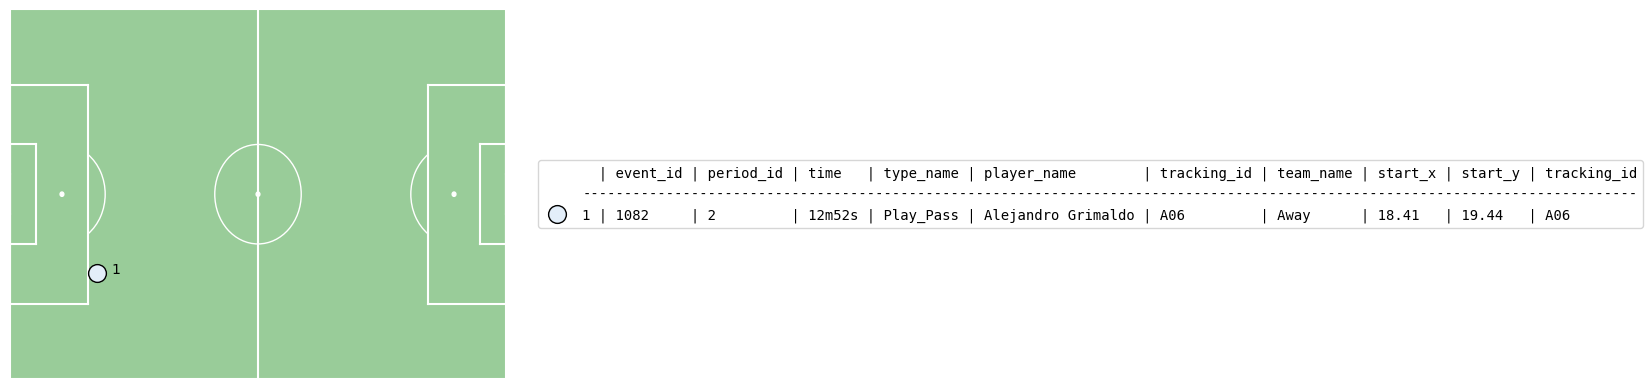

In [31]:
import datatools.matplotsoccer as mps

filtered_events = events.copy()#events[events["start_x"].notna() & events["start_y"].notna()]
filtered_events = filtered_events[filtered_events["player_id"].notna()]
# filtered_events = events[events["event_id"] >= 0] # 389
# 389: overview
# 689: application
# filtered_events = filtered_events[filtered_events["type_name"].isin(["Play_Pass"])].reset_index(drop=True)
idx = 1082#765#183#1299#1196#64#events[(events["player_id"] == "DFL-OBJ-J01589")].index[5]#events[(events["player_id"] == "DFL-OBJ-00264N") & (events["start_x"] < 105//2) & (events["start_y"] < 68//2)].index[25]#1371#528#1371#528#1371#1354#330, 1196
e = events[idx:idx+1].copy()
l = min(1, len(e))

for j in range(0, l):
    row = list(e[j:j+1].itertuples())[0]
    i = row.Index
    a = filtered_events.loc[i-0: i+2].copy()

    for col in ["start_x", "start_y"]:
        a[col] = a[col].apply(lambda x : round(x, 2))

    a["time"] = a["time_seconds"].apply(lambda t: f"{int(t // 60)}m{int(t % 60)}s")
    a["player_name"] = a["player_id"].apply(lambda x: team_sheets.loc[team_sheets["player_id"] == x, "player"].values[0])
    a["team_name"] = a["team_id"].apply(lambda x: team_sheets.loc[team_sheets["team_id"] == x, "team"].values[0])

    a["tracking_id"] = a["player_id"].apply(lambda x: team_sheets.loc[team_sheets["player_id"] == x, "xID"].values[0])
    a["tracking_id"] = a[["tracking_id", "team_name"]].apply(lambda x: f"{x[1][0]}{x[0]:02d}", axis=1)  
    
    cols = ["event_id", "period_id", "time", "type_name", "player_name", "tracking_id", "team_name", "start_x", "start_y", "tracking_id"]
    labeltitle = ["event_id", "period_id", "time", "type_name", "player_name", "tracking_id", "team_name", "start_x", "start_y", "tracking_id"]

    mps.actions(a[["start_x", "start_y"]],
                a.type_name,
                team=a.team_name,
                label=a[cols],
                color="green",
                labeltitle = labeltitle,
                zoom=False,
                show=False,
                show_legend= True)

In [32]:
a

,type_name,time_seconds,team_id,player_id,outcome,timestamp,minute,second,qualifier,period_id,...,start_y,position,related_x,related_y,related_id,event_id,time,player_name,team_name,tracking_id
1082,Play_Pass,772.969,DFL-CLU-00000B,DFL-OBJ-J016J2,NaN,2024-04-06 16:52:58.299000+02:00,12.0,52.0,"{'PlayOrigin': 'oppositionHalf', 'FromOpenPlay...",2,...,19.44,DLM,28.000004,16.840029,DFL-OBJ-J01EAQ,1082,12m52s,Alejandro Grimaldo,Away,A06


In [33]:
#tracking_data = pd.read_csv(os.path.join(path, test_game_ids[2], 'positions.csv'))
tracking_data = pd.read_csv(os.path.join(path, test_game_ids[0], 'positions.csv'))

print(os.path.join(path, test_game_ids[0], 'positions.csv'))
tracking_data

/root/geonhee/PlayerImputer/data/DFL/DFL-MAT-J03YKM/positions.csv


,H00_x,H00_y,H01_x,H01_y,H02_x,H02_y,H03_x,H03_y,H04_x,H04_y,...,A17_speed,A18_vx,A18_vy,A18_speed,A19_vx,A19_vy,A19_speed,B00_vx,B00_vy,B00_speed
0,58.08,40.69,74.02,30.37,NaN,NaN,NaN,NaN,58.41,28.86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,58.05,40.64,74.06,30.37,NaN,NaN,NaN,NaN,58.38,28.89,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,58.02,40.60,74.09,30.36,NaN,NaN,NaN,NaN,58.36,28.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,57.97,40.56,74.12,30.36,NaN,NaN,NaN,NaN,58.34,28.93,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,57.93,40.51,74.17,30.35,NaN,NaN,NaN,NaN,58.33,28.95,...,5.37,NaN,NaN,NaN,-0.57,-0.04,0.57,10.71,3.46,11.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157141,NaN,NaN,46.78,38.26,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.46,-0.43,1.53,NaN,NaN,NaN,0.00,0.00,0.00
157142,NaN,NaN,46.76,38.26,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.46,-0.43,1.53,NaN,NaN,NaN,0.00,0.00,0.00
157143,NaN,NaN,46.75,38.27,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.42,-0.45,1.49,NaN,NaN,NaN,0.00,0.00,0.00
157144,NaN,NaN,46.74,38.27,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.38,-0.46,1.45,NaN,NaN,NaN,0.00,0.00,0.00


player_id: A06 loc: (18.410018, 19.4400468) action: Play_Pass time: 772.969
visible_area:  ((array([-24.4527808]), array([32.22154498])), (array([11.96770943]), array([63.70157498])), (array([36.50208207]), array([13.03664581])), (array([22.12707376]), array([0.61161556])))


(<Figure size 2080x1440 with 1 Axes>, <Axes: >)

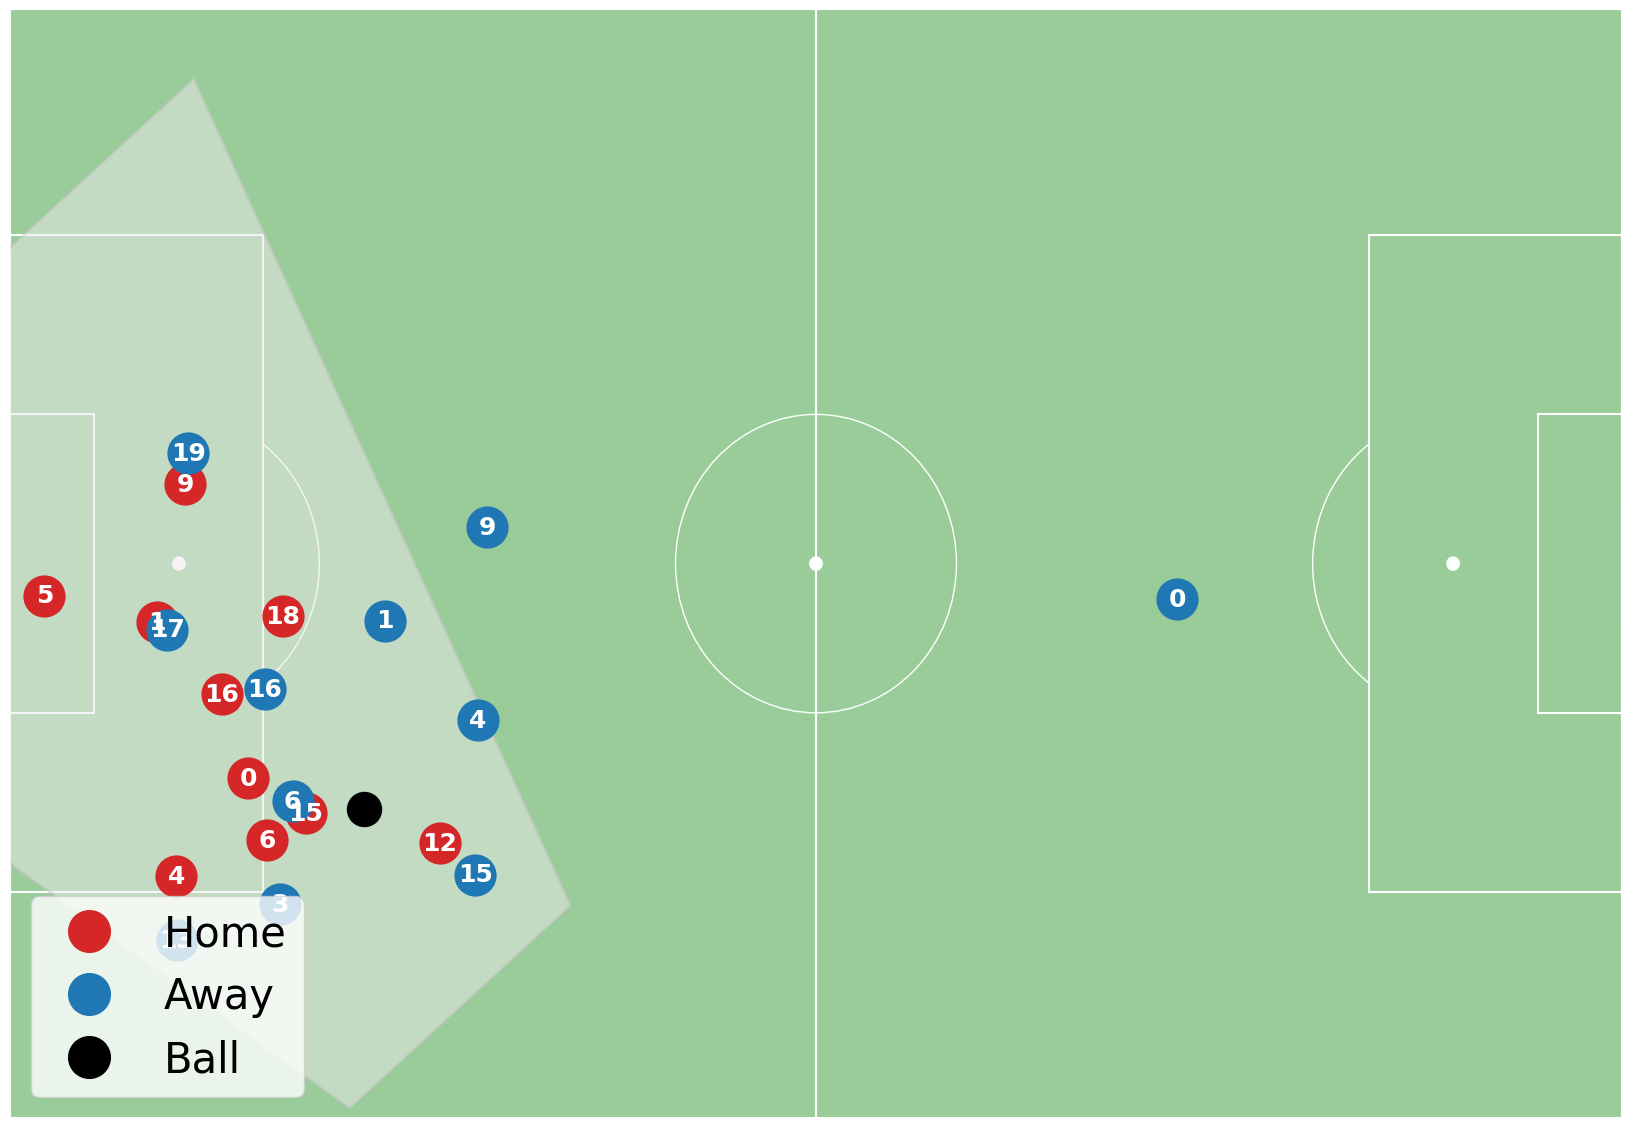

In [34]:
idx = a.iloc[0].event_id
before_maigin = 0.1
after_margin = 0

highlight = events[events["event_id"] == idx].iloc[0]
player = team_sheets[team_sheets["player_id"] == highlight.player_id].apply(lambda x: f"{x['team'][0]}{x['xID']:02d}", axis=1).values[0]
print("player_id:", player, "loc:", (highlight.start_x, highlight.start_y), "action:", highlight.type_name, "time:", highlight.time_seconds)

trace = tracking_data[
    (tracking_data["period_id"] == highlight.period_id) & 
    (tracking_data["time"] >= highlight.time_seconds-before_maigin) & 
    (tracking_data["time"] <= highlight.time_seconds+after_margin)]
# trace = trace.drop(columns=["B00_x", "B00_y"])
# trace = trace[["H03_x","H03_y","H05_x","H05_y", "H04_x","H04_y", "H08_x","H08_y", "H11_x", "H11_y", "H13_x", "H13_y", "H15_x", "H15_y",
#                "A07_x", "A07_y", "A14_x", "A14_y", "A18_x", "A18_y"]]
# trace = trace[["H06_x","H06_y","H07_x","H07_y", "H05_x","H05_y", "H09_x","H09_y", "H10_x", "H10_y",
#                "A08_x","A08_y", "A06_x", "A06_y", "A03_x", "A03_y", "A04_x", "A04_y", "A02_x", "A02_y", "A01_x", "A01_y"]]


visible_area = compute_camera_coverage(np.array([[highlight.start_x, highlight.start_y]]), 
                                       camera_info=(0, -20, 20, 30),
                                       pitch_size=(config.field_length, config.field_width))


print("visible_area: ", visible_area)

snapshot = TraceSnapshot(trace, visible_area=visible_area, play_left_to_right=False)
snapshot.plot(color="green")#, save_format="pdf")

In [11]:
# idx = a.iloc[0].event_id
# before_maigin = 0.1
# after_margin = 0.1
# highlight = events[events["event_id"] == idx].iloc[0]
# player = team_sheets[team_sheets["player_id"] == highlight.player_id].apply(lambda x: f"{x['team'][0]}{x['xID']:02d}", axis=1).values[0]
# print("player_id:", player, "loc:", (highlight.start_x, highlight.start_y), "action:", highlight.type_name, "time:", highlight.time_seconds)

# trace = tracking_data[
#     (tracking_data["period_id"] == highlight.period_id) & 
#     (tracking_data["time"] >= highlight.time_seconds-before_maigin) & 
#     (tracking_data["time"] <= highlight.time_seconds+after_margin)]
# #trace = trace.drop(columns=["B00_x", "B00_y"])
# # trace = trace[["H03_x","H03_y","H05_x","H05_y", "H04_x","H04_y", "H08_x","H08_y", "H11_x", "H11_y", "H13_x", "H13_y", "H15_x", "H15_y",
# #                "A07_x", "A07_y", "A14_x", "A14_y", "A18_x", "A18_y"]]
# # trace = trace[["H06_x","H06_y","H07_x","H07_y", "H05_x","H05_y", "H09_x","H09_y", "H10_x", "H10_y",
# #                "A08_x","A08_y", "A06_x", "A06_y", "A03_x", "A03_y", "A04_x", "A04_y", "A02_x", "A02_y", "A01_x", "A01_y"]]


# visible_area = compute_camera_coverage(np.array([[highlight.start_x, highlight.start_y]]), 
#                                        camera_info=(0, -20, 20, 30),
#                                        pitch_size=(config.field_length, config.field_width))


# print("visible_area: ", visible_area)

# snapshot = TraceSnapshot(trace, visible_area=visible_area, play_left_to_right=False)
# snapshot.plot(color="white")#, save_format="pdf")

In [12]:
# v_cols = [col for col in trace.columns if col.endswith("_vx") and col.startswith("H")]
# trace[v_cols]

In [13]:
# idx = a.iloc[0].event_id
# before_maigin = 0.8
# after_margin = 0

# highlight = events[events["event_id"] == idx].iloc[0]
# player = team_sheets[team_sheets["player_id"] == highlight.player_id].apply(lambda x: f"{x['team'][0]}{x['xID']:02d}", axis=1).values[0]
# print("player_id:", player, "loc:", (highlight.start_x, highlight.start_y), "action:", highlight.type_name, "time:", highlight.time_seconds)

# trace = tracking_data[
#     (tracking_data["period_id"] == highlight.period_id) & 
#     (tracking_data["time"] >= highlight.time_seconds-before_maigin) & 
#     (tracking_data["time"] <= highlight.time_seconds+after_margin)]
# trace = trace.drop(columns=["B00_x", "B00_y"])
# trace = trace[["H05_x", "H05_y", "H15_x", "H15_y"]]
# # trace = trace[["H06_x","H06_y","H07_x","H07_y", "H05_x","H05_y", "H09_x","H09_y", "H10_x", "H10_y",
# #                "A08_x","A08_y", "A06_x", "A06_y", "A03_x", "A03_y", "A04_x", "A04_y", "A02_x", "A02_y", "A01_x", "A01_y"]]


# visible_area = compute_camera_coverage(np.array([[highlight.start_x, highlight.start_y]]), 
#                                        camera_info=(0, -20, 20, 30),
#                                        pitch_size=(config.field_length, config.field_width))


# print("visible_area: ", visible_area)

# snapshot = TraceSnapshot(trace, visible_area=None, play_left_to_right=False)
# snapshot.plot(color="white")#, save_format="pdf")

In [14]:
# idx = a.iloc[0].event_id
# before_maigin = 0.2
# after_margin = 0.2

# highlight = events[events["event_id"] == idx].iloc[0]
# player = team_sheets[team_sheets["player_id"] == highlight.player_id].apply(lambda x: f"{x['team'][0]}{x['xID']:02d}", axis=1).values[0]
# print("player_id:", player, "loc:", (highlight.start_x, highlight.start_y), "action:", highlight.type_name, "time:", highlight.time_seconds)

# trace = tracking_data[
#     (tracking_data["period_id"] == highlight.period_id) & 
#     (tracking_data["time"] >= highlight.time_seconds-before_maigin) & 
#     (tracking_data["time"] <= highlight.time_seconds+after_margin)]
# trace = trace.drop(columns=["B00_x", "B00_y"])
# trace = trace[["H03_x","H03_y","H05_x","H05_y", "H04_x","H04_y", "H08_x","H08_y", "H11_x", "H11_y", "H13_x", "H13_y", "H15_x", "H15_y", 
#                "A12_x", "A12_y", "A09_x", "A09_y", "A07_x", "A07_y", "A14_x", "A14_y", "A18_x", "A18_y"]]
# # trace = trace[["H06_x","H06_y","H07_x","H07_y", "H05_x","H05_y", "H09_x","H09_y", "H10_x", "H10_y",
# #                "A08_x","A08_y", "A06_x", "A06_y", "A03_x", "A03_y", "A04_x", "A04_y", "A02_x", "A02_y", "A01_x", "A01_y"]]


# # visible_area = compute_camera_coverage(np.array([[highlight.start_x, highlight.start_y]]), 
# #                                        camera_info=(0, -20, 20, 30),
# #                                        pitch_size=(config.field_length, config.field_width))
# visible_area = compute_camera_coverage(np.array([[highlight.start_x, highlight.start_y]]), 
#                                        camera_info=(0, -20, 20, 30),
#                                        pitch_size=(config.field_length, config.field_width))

# print("visible_area: ", visible_area)

# snapshot = TraceSnapshot(trace, visible_area=visible_area, play_left_to_right=False)
# snapshot.plot(color="white")#, save_format="pdf")

In [355]:
print("test game ids: ", test_game_ids)
test_dataset = ImputerDataset(
    test_game_ids,
    path,
    model="heatmap",
    xfns=["heatmap", "freeze_frame"],
    yfns=["coordinates"],
    window=1,
    use_transform=False,
    play_left_to_right=True
)

test_dataset._features

test game ids:  ['DFL-MAT-J03YKY']


100%|██████████| 1/1 [00:22<00:00, 22.32s/it]


features_lst Shape: torch.Size([1445, 1, 40, 68, 105])
labels_lst Shape: torch.Size([1445, 1, 40, 2])
freeze_frame Shape: torch.Size([1445, 1, 22, 5])
freeze_frame mask Shape: 1445


,A00_heatmap,A01_heatmap,A02_heatmap,A03_heatmap,A04_heatmap,A05_heatmap,A06_heatmap,A07_heatmap,A08_heatmap,A09_heatmap,...,H10_heatmap,H11_heatmap,H12_heatmap,H13_heatmap,H14_heatmap,H15_heatmap,H16_heatmap,H17_heatmap,H18_heatmap,H19_heatmap
0,"[[0.00014005602240896358, 0.000140056022408963...","[[0.00014005602240896358, 0.000140056022408963...","[[0.00014005602240896358, 0.000140056022408963...","[[0.00014005602240896358, 0.000140056022408963...","[[3.642762221400332e-08, 3.741865429090272e-08...","[[0.00014005602240896358, 0.000140056022408963...","[[6.848420056401877e-06, 6.908425337192533e-06...","[[2.967417182780726e-06, 3.054132863847072e-06...","[[9.290348220040037e-07, 9.377012211584628e-07...","[[5.198778007370903e-06, 5.343268139633266e-06...",...,"[[0.00014005602240896358, 0.000140056022408963...","[[0.00014005602240896358, 0.000140056022408963...","[[0.00014005602240896358, 0.000140056022408963...","[[5.4435951585034934e-05, 5.46829116740988e-05...","[[0.00014005602240896358, 0.000140056022408963...","[[0.0002864884727370301, 0.0002877597692229048...","[[0.00014005602240896358, 0.000140056022408963...","[[2.811542263499813e-05, 2.8611482805984002e-0...","[[0.00014005602240896358, 0.000140056022408963...","[[3.978996784984087e-05, 4.0007726642770136e-0..."
1,"[[0.00014005602240896358, 0.000140056022408963...","[[0.00014005602240896358, 0.000140056022408963...","[[0.00014005602240896358, 0.000140056022408963...","[[0.00014005602240896358, 0.000140056022408963...","[[3.642762221400332e-08, 3.741865429090272e-08...","[[0.00014005602240896358, 0.000140056022408963...","[[6.848420056401877e-06, 6.908425337192533e-06...","[[2.967417182780726e-06, 3.054132863847072e-06...","[[9.290348220040037e-07, 9.377012211584628e-07...","[[5.198778007370903e-06, 5.343268139633266e-06...",...,"[[0.00014005602240896358, 0.000140056022408963...","[[0.00014005602240896358, 0.000140056022408963...","[[0.00014005602240896358, 0.000140056022408963...","[[5.4435951585034934e-05, 5.46829116740988e-05...","[[0.00014005602240896358, 0.000140056022408963...","[[0.0002864884727370301, 0.0002877597692229048...","[[0.00014005602240896358, 0.000140056022408963...","[[2.811542263499813e-05, 2.8611482805984002e-0...","[[0.00014005602240896358, 0.000140056022408963...","[[3.978996784984087e-05, 4.0007726642770136e-0..."
2,"[[0.00014005602240896358, 0.000140056022408963...","[[0.00014005602240896358, 0.000140056022408963...","[[0.00014005602240896358, 0.000140056022408963...","[[0.00014005602240896358, 0.000140056022408963...","[[3.642762221400332e-08, 3.741865429090272e-08...","[[0.00014005602240896358, 0.000140056022408963...","[[6.848420056401877e-06, 6.908425337192533e-06...","[[2.967417182780726e-06, 3.054132863847072e-06...","[[9.290348220040037e-07, 9.377012211584628e-07...","[[5.198778007370903e-06, 5.343268139633266e-06...",...,"[[0.00014005602240896358, 0.000140056022408963...","[[0.00014005602240896358, 0.000140056022408963...","[[0.00014005602240896358, 0.000140056022408963...","[[5.4435951585034934e-05, 5.46829116740988e-05...","[[0.00014005602240896358, 0.000140056022408963...","[[0.0002864884727370301, 0.0002877597692229048...","[[0.00014005602240896358, 0.000140056022408963...","[[2.811542263499813e-05, 2.8611482805984002e-0...","[[0.00014005602240896358, 0.000140056022408963...","[[3.978996784984087e-05, 4.0007726642770136e-0..."
3,"[[0.00014005602240896358, 0.000140056022408963...","[[0.00014005602240896358, 0.000140056022408963...","[[0.00014005602240896358, 0.000140056022408963...","[[0.00014005602240896358, 0.000140056022408963...","[[3.642762221400332e-08, 3.741865429090272e-08...","[[0.00014005602240896358, 0.000140056022408963...","[[6.848420056401877e-06, 6.908425337192533e-06...","[[2.967417182780726e-06, 3.054132863847072e-06...","[[9.290348220040037e-07, 9.377012211584628e-07...","[[5.198778007370903e-06, 5.343268139633266e-06...",...,"[[0.00014005602240896358, 0.000140056022408963...","[[0.00014005602240896358, 0.0001400560

In [356]:
test_loader = DataLoader(
    test_dataset,
    shuffle=False,
    batch_size = 1,
    num_workers = 80,
    pin_memory = True
)
component = press.HeatmapComponent(params=None)

In [357]:
df = component.test(test_dataset)

1445it [00:04, 339.94it/s]


Accuracy: 53.005867453268785
x: 14.524, y: 8.524, xy: 18.349


In [358]:
df1 = component.predict_freeze_frame(test_dataset)

1445it [00:07, 202.59it/s]


x: 9.876, y: 6.571, xy: 13.068
Accuracy: 43.51414262537914
----Error In Camera----
x: 6.909951319821994, y: 4.986368055600765, xy: 9.462356864167864


In [275]:
events = test_dataset.events
print(events["game_id"].unique())
events

['DFL-MAT-J03YHA']


,type_name,time_seconds,team_id,player_id,outcome,timestamp,minute,second,qualifier,period_id,...,start_x,start_y,position,related_x,related_y,related_id,event_id,period_time_seconds,time_bin,freeze_frame
0,KickOff_Play_Pass,0.000,DFL-CLU-00000D,DFL-OBJ-0027YK,NaN,2023-12-10 15:31:23.410000+01:00,0.0,0.0,"{'TeamRight': 'DFL-CLU-00000D', 'TeamLeft': 'D...",1,...,53.610000,33.760000,STR,28.000000,32.570000,DFL-OBJ-0027W7,0,0.000,0,"[[H00, nan, nan, False, True, False], [H01, na..."
1,Play_Pass,1.811,DFL-CLU-00000D,DFL-OBJ-0027W7,NaN,2023-12-10 15:31:25.221000+01:00,0.0,1.0,"{'Recipient': 'DFL-OBJ-00278S', 'BallPossessio...",1,...,28.120013,32.620022,IVL,62.360088,50.490018,DFL-OBJ-00278S,1,1.811,0,"[[H00, nan, nan, False, True, False], [H01, na..."
2,Play_Pass,6.163,DFL-CLU-00000D,DFL-OBJ-00278S,NaN,2023-12-10 15:31:29.573000+01:00,0.0,6.0,"{'Recipient': 'DFL-OBJ-J01K8D', 'BallPossessio...",1,...,77.010001,54.340001,STL,64.900017,52.230007,DFL-OBJ-J01K8D,2,6.163,0,"[[H00, nan, nan, False, True, False], [H01, na..."
3,Play_Pass,8.107,DFL-CLU-00000D,DFL-OBJ-J01K8D,NaN,2023-12-10 15:31:31.517000+01:00,0.0,8.0,"{'Recipient': 'DFL-OBJ-0028I9', 'BallPossessio...",1,...,70.499969,55.259979,ORM,83.820057,59.039943,DFL-OBJ-0028I9,3,8.107,0,"[[H00, nan, nan, False, True, False], [H01, na..."
4,Play_Pass,12.982,DFL-CLU-00000D,DFL-OBJ-0028I9,NaN,2023-12-10 15:31:36.392000+01:00,0.0,12.0,"{'Recipient': 'DFL-OBJ-0025AD', 'BallPossessio...",1,...,73.390065,59.640029,OLM,58.890022,60.430029,DFL-OBJ-0025AD,4,12.982,0,"[[H00, nan, nan, False, True, False], [H01, na..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1736,Play_Pass,2987.487,DFL-CLU-00000D,DFL-OBJ-00264T,NaN,2023-12-10 17:28:17.297000+01:00,49.0,47.0,"{'Recipient': 'DFL-OBJ-J01XFZ', 'BallPossessio...",2,...,41.539994,17.469961,IVR,48.189983,5.659978,DFL-OBJ-J01XFZ,1736,2987.487,0,"[[H00, nan, nan, False, True, False], [H01, na..."
1737,Play_Pass,2990.134,DFL-CLU-00000D,DFL-OBJ-J01XFZ,NaN,2023-12-10 17:28:19.944000+01:00,49.0,50.0,"{'Recipient': 'DFL-OBJ-002GAR', 'BallPossessio...",2,...,46.470028,3.239961,RV,72.109994,20.999944,DFL-OBJ-002GAR,1737,2990.134,0,"[[H00, nan, nan, False, True, False], [H01, na..."
1738,BallClaiming,2996.526,DFL-CLU-00000B,DFL-OBJ-002GAR,NaN,2023-12-10 17:28:26.336000+01:00,49.0,56.0,"{'BallPossessionPhase': '1712', 'Player': 'DFL...",2,...,10.949969,65.540007,IVL,NaN,NaN,NaN,1738,2996.526,0,"[[H00, nan, nan, False, False, False], [H01, n..."
1739,Play_Pass,2996.527,DFL-CLU-00000B,DFL-OBJ-002GAR,NaN,2023-12-10 17:28:26.337000+01:00,49.0,56.0,"{'Recipient': 'DFL-OBJ-0026NY', 'BallPossessio...",2,...,10.949964,65.540008,IVL,3.119994,39.800008,DFL-OBJ-0026NY,1739,2996.527,0,"[[H00, nan, nan, False, False, False], [H01, n..."


In [276]:
tracking_data = pd.read_csv(os.path.join(base_path, "data", "DFL", events["game_id"].unique()[0], 'positions.csv'))
tracking_data

,H00_x,H00_y,H01_x,H01_y,H02_x,H02_y,H03_x,H03_y,H04_x,H04_y,...,A17_speed,A18_vx,A18_vy,A18_speed,A19_vx,A19_vy,A19_speed,B00_vx,B00_vy,B00_speed
0,NaN,NaN,NaN,NaN,NaN,NaN,96.07,33.67,71.14,20.88,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,96.03,33.67,71.10,20.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,96.00,33.67,71.07,20.84,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,95.97,33.67,71.04,20.81,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,95.93,33.67,71.00,20.79,...,2.09,-0.5,-0.61,0.79,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148583,NaN,NaN,NaN,NaN,NaN,NaN,21.48,28.65,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
148584,NaN,NaN,NaN,NaN,NaN,NaN,21.46,28.61,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
148585,NaN,NaN,NaN,NaN,NaN,NaN,21.45,28.56,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
148586,NaN,NaN,NaN,NaN,NaN,NaN,21.45,28.51,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


In [277]:
team_sheets = pd.read_csv(os.path.join(base_path, "data", "DFL", events["game_id"].unique()[0], 'teams.csv'))

print(team_sheets["team_id"].unique())
team_sheets

['DFL-CLU-00000D' 'DFL-CLU-00000B']


,player,position,team,jID,player_id,team_id,xID
0,P. Stenzel,None,Home,15,DFL-OBJ-0026MA,DFL-CLU-00000D,0
1,F. Bredlow,None,Home,1,DFL-OBJ-0027Q9,DFL-CLU-00000D,1
2,G. Haraguchi,None,Home,17,DFL-OBJ-0002E5,DFL-CLU-00000D,2
3,A. Nübel,TW,Home,33,DFL-OBJ-0002HC,DFL-CLU-00000D,3
4,M. Mittelstädt,LV,Home,7,DFL-OBJ-0025AD,DFL-CLU-00000D,4
5,A. Karazor,DML,Home,16,DFL-OBJ-0027SD,DFL-CLU-00000D,5
6,W. Anton,IVR,Home,2,DFL-OBJ-00264T,DFL-CLU-00000D,6
7,Serhou Guirassy,STL,Home,9,DFL-OBJ-00278S,DFL-CLU-00000D,7
8,D. Zagadou,IVL,Home,23,DFL-OBJ-0027W7,DFL-CLU-00000D,8
9,D. Undav,STR,Home,26,DFL-OBJ-0027YK,DFL-CLU-00000D,9


In [278]:
test_dataset.play_left_to_right

True

start loc:  (37.21993280000001, 11.240015999999997)
visible_area:  ((array([17.90964781]), array([19.70184273])), (array([42.39479764]), array([31.67798048])), (array([47.47595092]), array([5.69297484])), (array([35.30255845]), array([-0.26125563])))


(<Figure size 2080x1440 with 1 Axes>, <Axes: >)

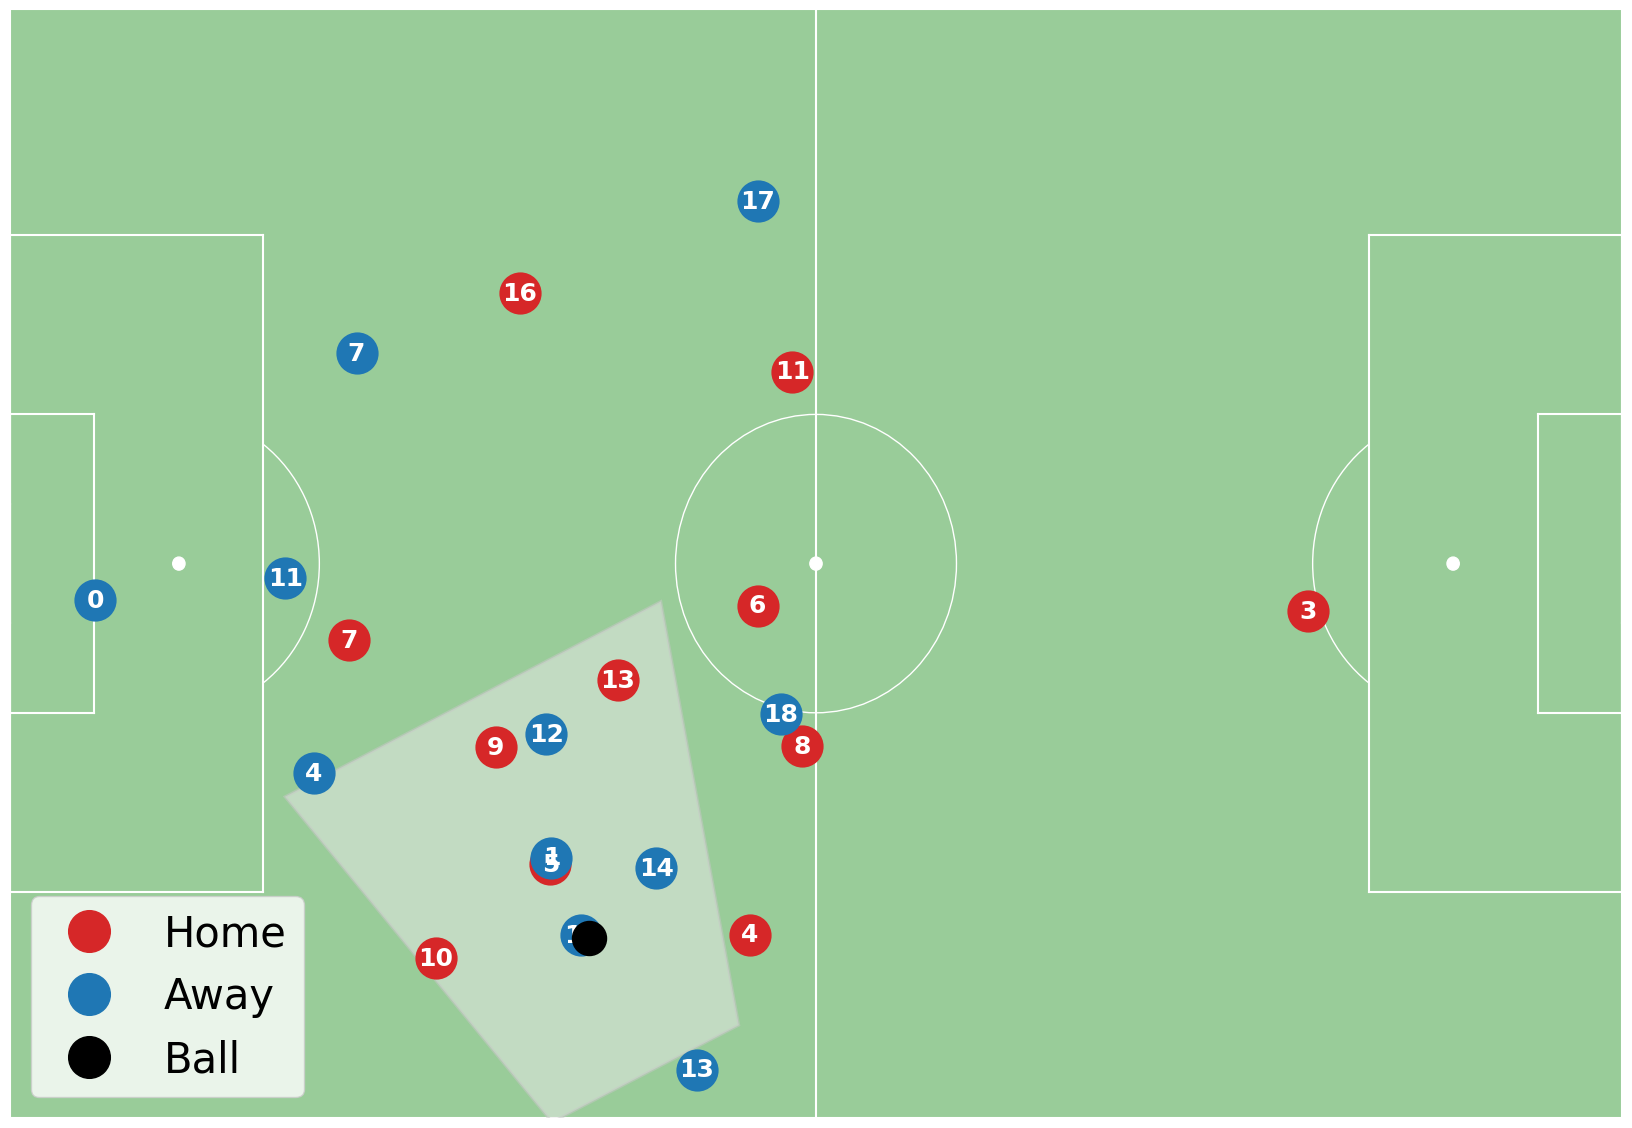

In [283]:
event_id = 628	#169#356	663
before_maigin = 10
after_margin = 0

highlight = events[events["event_id"] == event_id].iloc[0]

period_traces = tracking_data[tracking_data["period_id"] == highlight.period_id].reset_index(drop=True)
closest_idx = period_traces["time"].sub(highlight.time_seconds).abs().idxmin()
trace = period_traces.loc[[closest_idx]]

# 시각화: 360에 포착되지 않는 선수 제거
# except_id = ["H10", "H13","H14","H01","H08","H09", "H03", "A07","A12","A14","A16","A13","A06", "A01"]
# trace = trace.drop(columns=[f"{key}_{coord}" for key in except_id for coord in ["x", "y"]])

visible_area = compute_camera_coverage(np.array([[highlight.start_x, highlight.start_y]]), 
                                       camera_info=(0, -20, 20, 30),
                                       pitch_size=(config.field_length, config.field_width))

print("start loc: ", (highlight.start_x, highlight.start_y))
print("visible_area: ", visible_area)

snapshot = TraceSnapshot(trace, visible_area=visible_area, play_left_to_right=False)
# snapshot.plot(save_format="png")
snapshot.plot()

visible_area:  ((array([17.90964781]), array([19.70184273])), (array([42.39479764]), array([31.67798048])), (array([47.47595092]), array([5.69297484])), (array([35.30255845]), array([-0.26125563])))
not exist ball trajectory


(<Figure size 2080x1440 with 1 Axes>, <Axes: >)

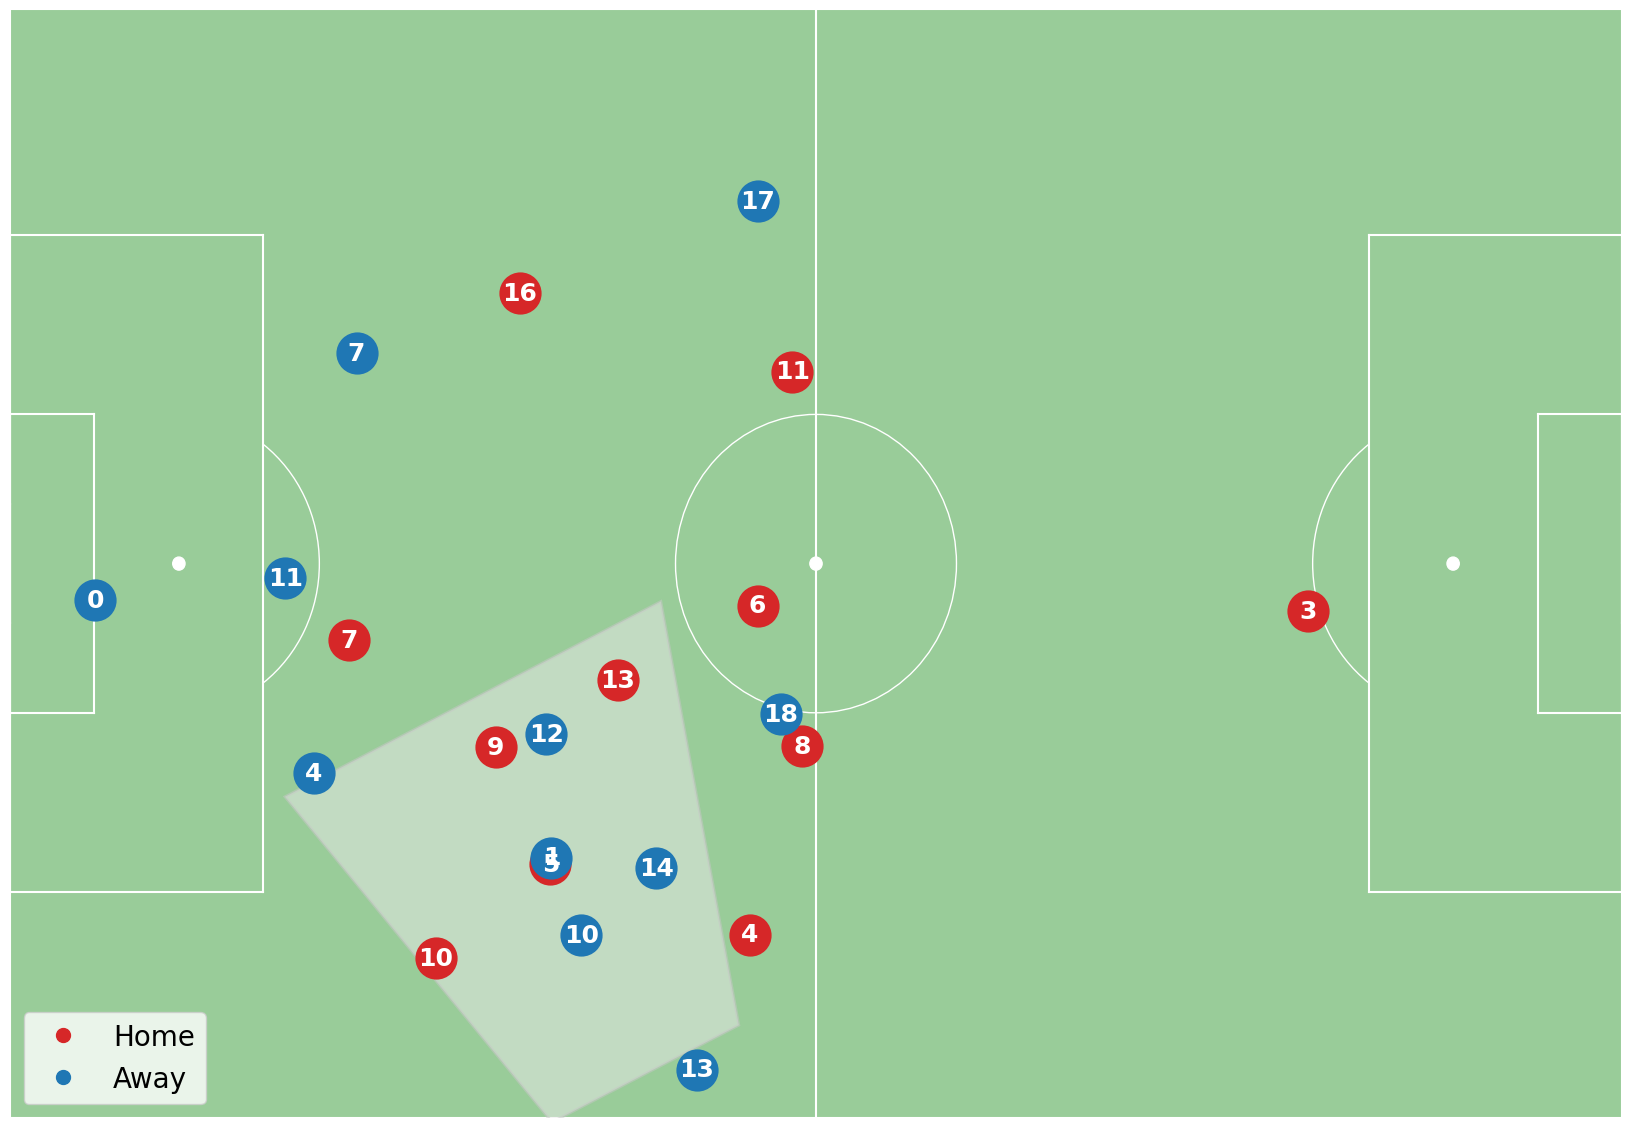

In [284]:
highlight = events[events["event_id"] == event_id].iloc[0]

row = {}
for pid, (x, y) in df.loc[event_id, "target"].items():
    row[f"{pid}_x"] = x
    row[f"{pid}_y"] = y
trace = pd.DataFrame.from_dict(row, orient='index').T

rotate_team = "H"
if test_dataset.play_left_to_right:
    away_x_cols = [col for col in trace.columns if col.startswith(rotate_team) and col.endswith("_x")]
    away_y_cols = [col for col in trace.columns if col.startswith(rotate_team) and col.endswith("_y")]
    trace[away_x_cols] = config.field_length - trace[away_x_cols].values
    trace[away_y_cols] = config.field_width - trace[away_y_cols].values

visible_area = compute_camera_coverage(np.array([[highlight.start_x, highlight.start_y]]), 
                                       camera_info=(0, -20, 20, 30),
                                       pitch_size=(config.field_length, config.field_width))

print("visible_area: ", visible_area)

snapshot = TraceSnapshot(trace, visible_area=visible_area, play_left_to_right=False)
snapshot.plot()

visible_area:  ((array([17.90964781]), array([19.70184273])), (array([42.39479764]), array([31.67798048])), (array([47.47595092]), array([5.69297484])), (array([35.30255845]), array([-0.26125563])))
not exist ball trajectory


(<Figure size 2080x1440 with 1 Axes>, <Axes: >)

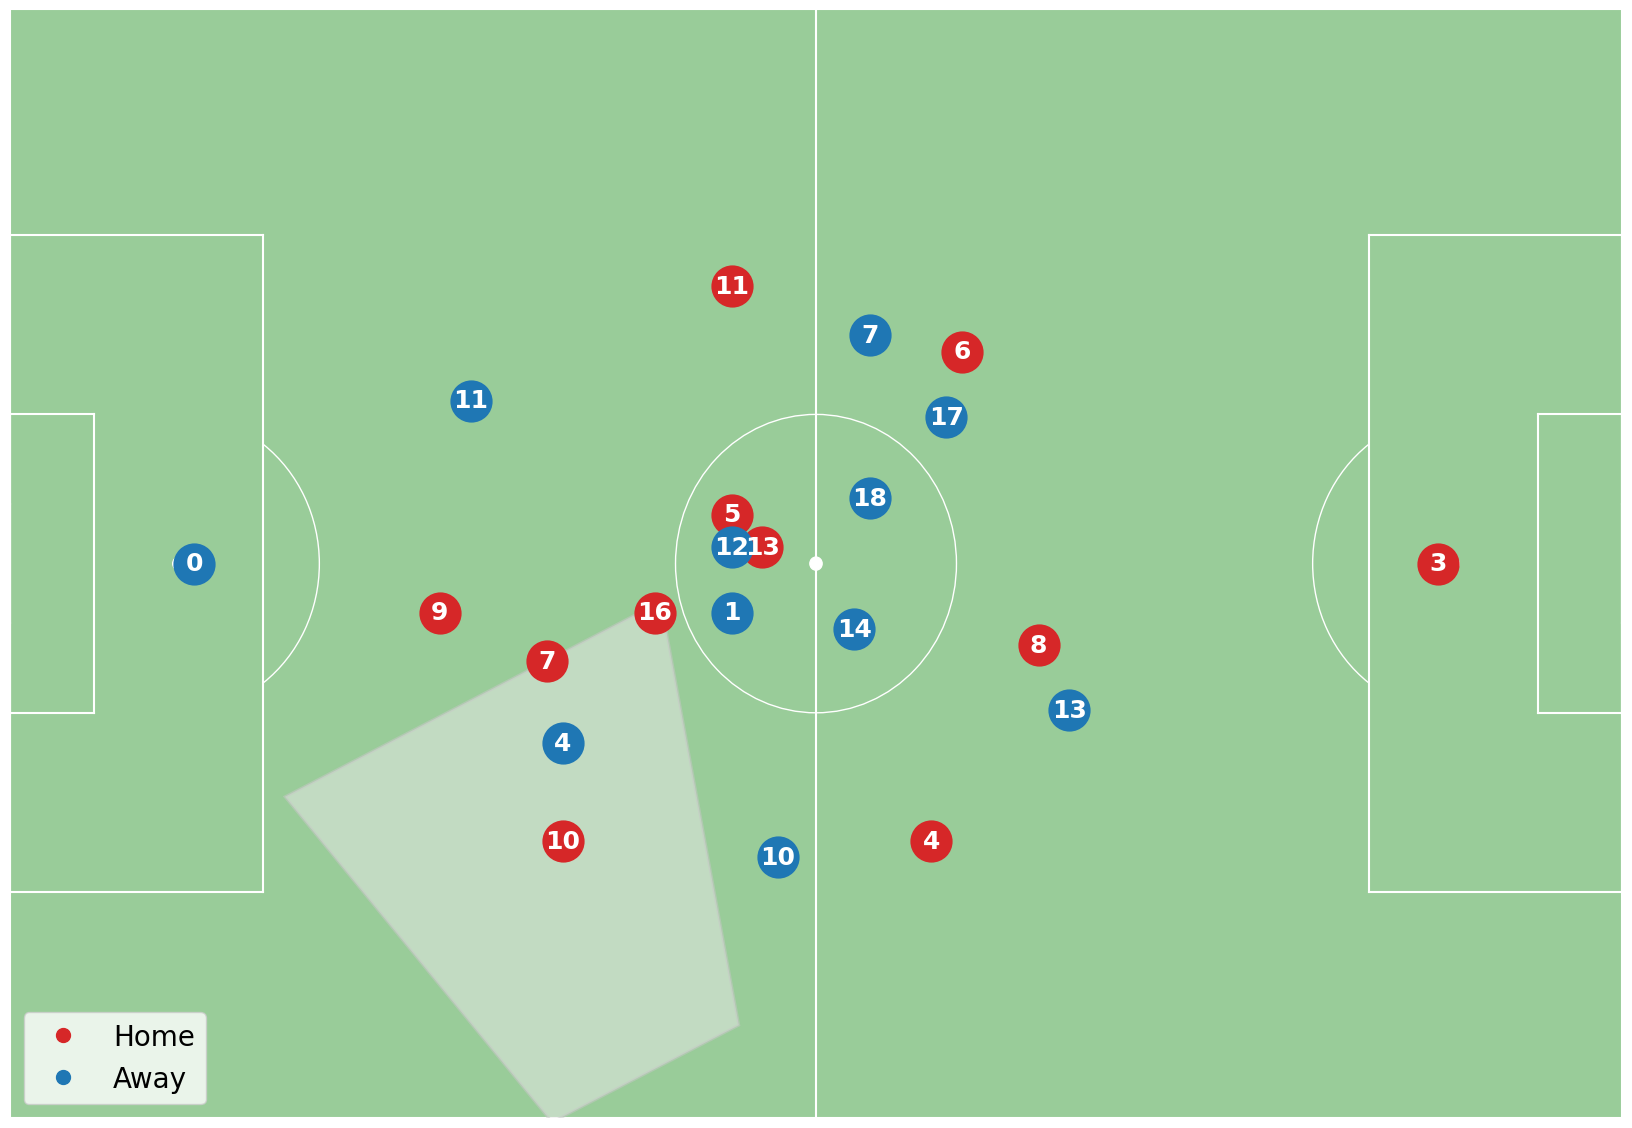

In [285]:
highlight = events[events["event_id"] == event_id].iloc[0]

row = {}
for pid, (x, y) in df.loc[event_id, "pred"].items():
    row[f"{pid}_x"] = x
    row[f"{pid}_y"] = y
trace = pd.DataFrame.from_dict(row, orient='index').T

rotate_team = "H"
if test_dataset.play_left_to_right:
    away_x_cols = [col for col in trace.columns if col.startswith(rotate_team) and col.endswith("_x")]
    away_y_cols = [col for col in trace.columns if col.startswith(rotate_team) and col.endswith("_y")]
    trace[away_x_cols] = config.field_length - trace[away_x_cols].values
    trace[away_y_cols] = config.field_width - trace[away_y_cols].values

visible_area = compute_camera_coverage(np.array([[highlight.start_x, highlight.start_y]]), 
                                       camera_info=(0, -20, 20, 30),
                                       pitch_size=(config.field_length, config.field_width))

print("visible_area: ", visible_area)

snapshot = TraceSnapshot(trace, visible_area=visible_area, play_left_to_right=False)
snapshot.plot()

visible_area:  ((array([17.90964781]), array([19.70184273])), (array([42.39479764]), array([31.67798048])), (array([47.47595092]), array([5.69297484])), (array([35.30255845]), array([-0.26125563])))
not exist ball trajectory


(<Figure size 2080x1440 with 1 Axes>, <Axes: >)

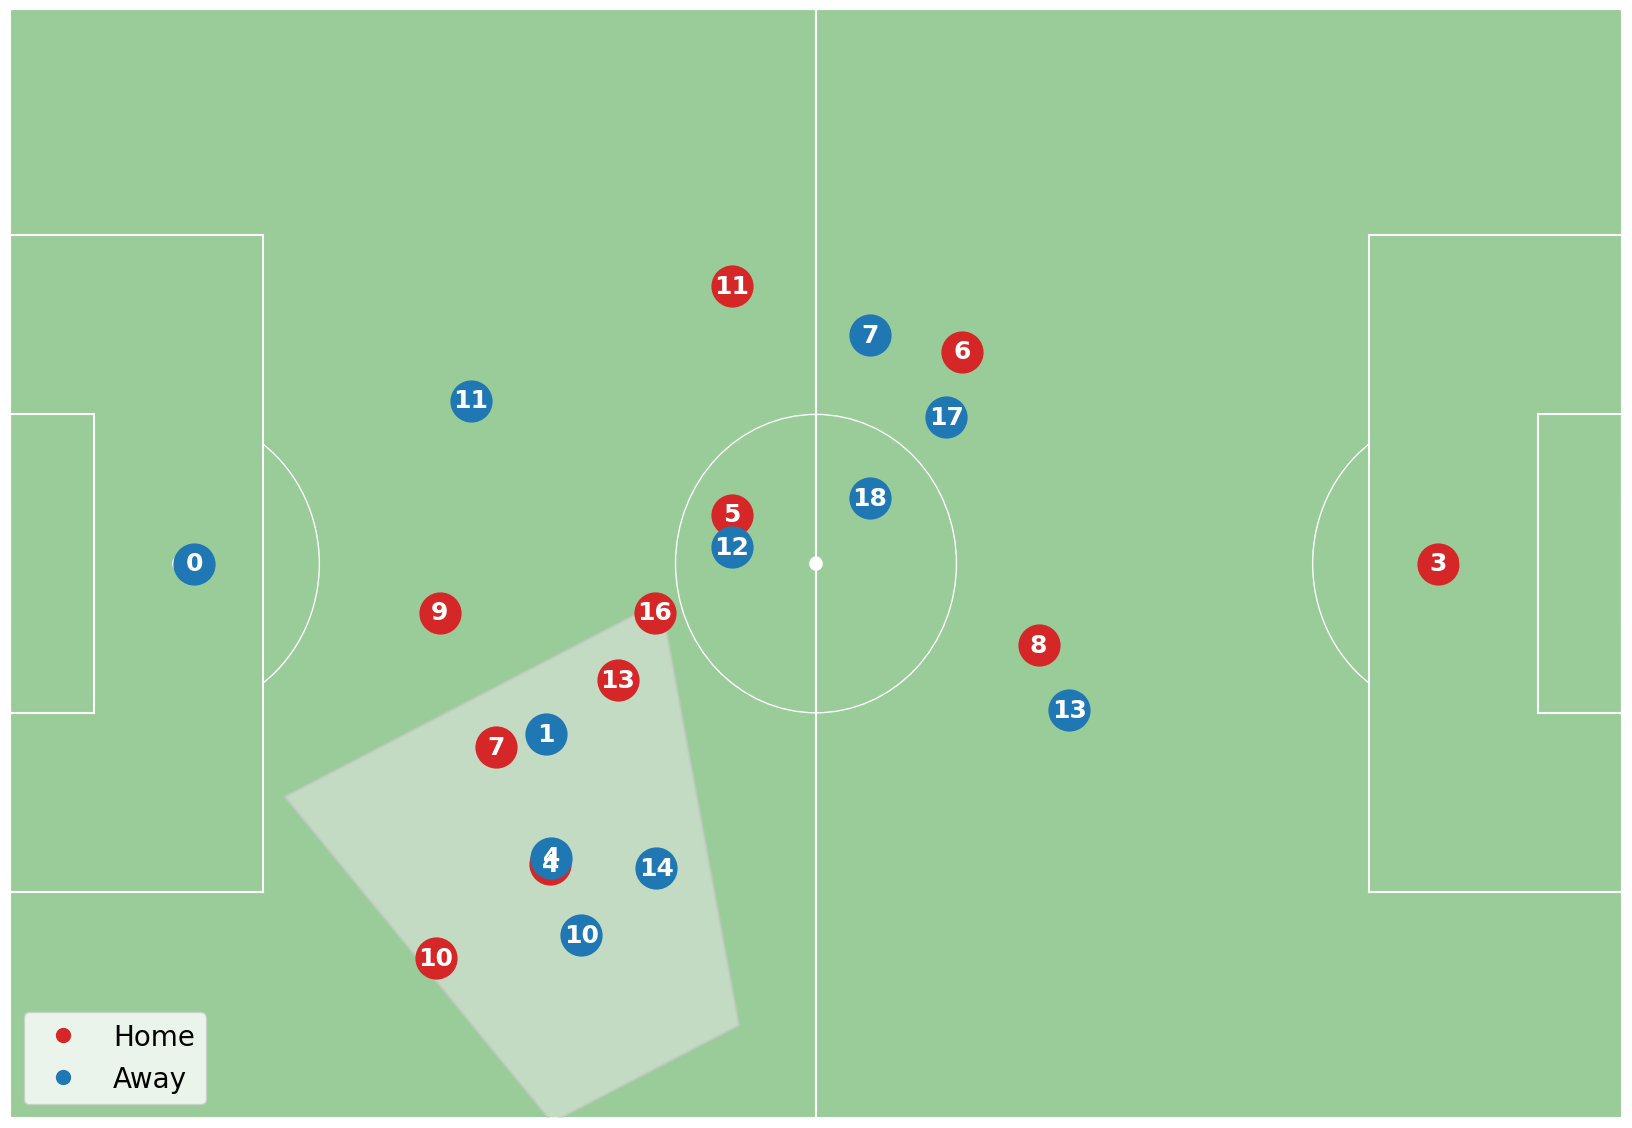

In [286]:
highlight = events[events["event_id"] == event_id].iloc[0]

row = {}
for pid, (x, y) in df1.loc[event_id, "pred"].items():
    row[f"{pid}_x"] = x
    row[f"{pid}_y"] = y
trace = pd.DataFrame.from_dict(row, orient='index').T

if test_dataset.play_left_to_right:
    away_x_cols = [col for col in trace.columns if col.startswith(rotate_team) and col.endswith("_x")]
    away_y_cols = [col for col in trace.columns if col.startswith(rotate_team) and col.endswith("_y")]
    trace[away_x_cols] = config.field_length - trace[away_x_cols].values
    trace[away_y_cols] = config.field_width - trace[away_y_cols].values

visible_area = compute_camera_coverage(np.array([[highlight.start_x, highlight.start_y]]), 
                                       camera_info=(0, -20, 20, 30),
                                       pitch_size=(config.field_length, config.field_width))

print("visible_area: ", visible_area)

snapshot = TraceSnapshot(trace, visible_area=visible_area, play_left_to_right=False)
snapshot.plot()